Rows after cleaning: 4028
Number of features used: 15

 LOGISTIC REGRESSION METRICS 
          Scratch Test  sklearn Test
LogLoss       0.709017      0.727058
Accuracy      0.480697      0.466999
F1            0.568769      0.529670


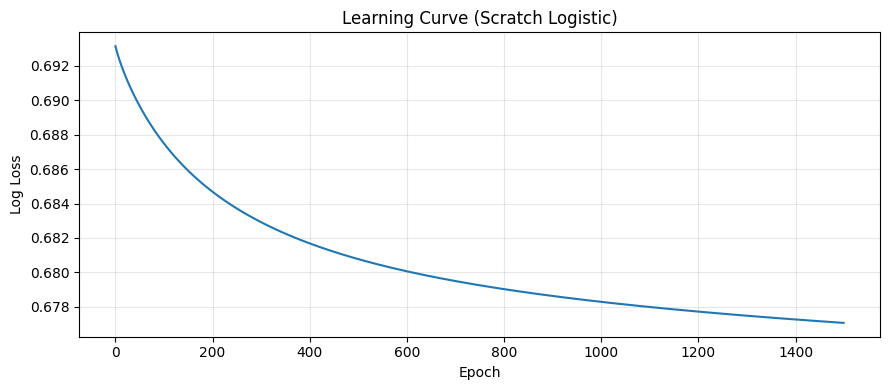

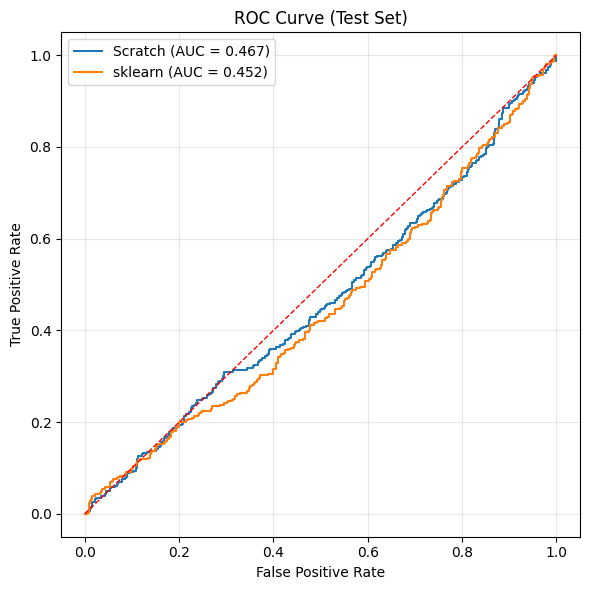

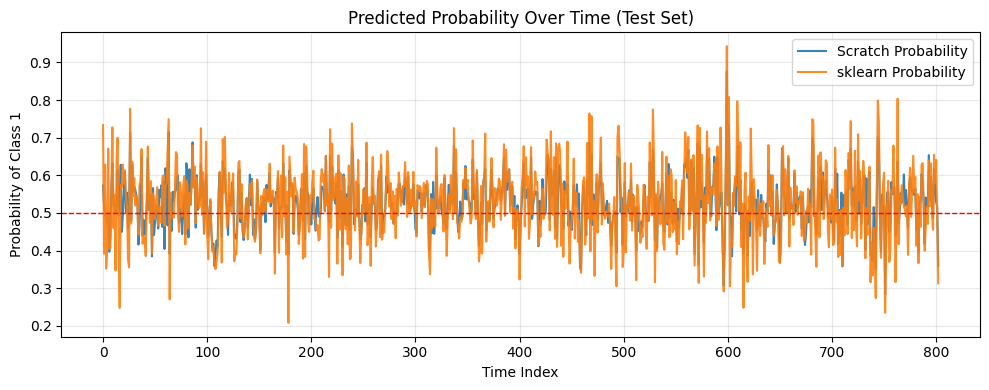

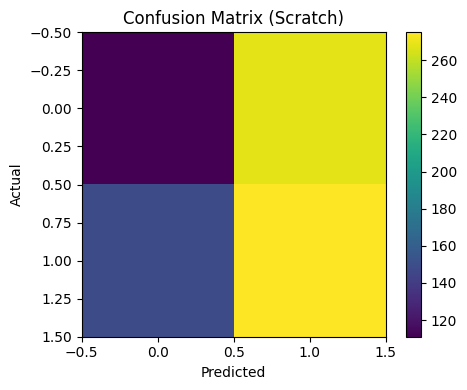

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    log_loss, accuracy_score, f1_score,
    confusion_matrix
)

WINDOW_SIZE = 14
DATA_PATH = 'SnP_daily_update_AMZN_features_with_target.csv'
FEATURE_PATH = 'AMZN_methods_all_in_one.csv'
TARGET_COL = 'y_ret_t1'

# --------------------------
# 1) Load data and features
# --------------------------
df = pd.read_csv(DATA_PATH)
feature_df = pd.read_csv(FEATURE_PATH)

feature_cols = [c for c in feature_df['feature'].tolist()
                if c in df.columns and c != TARGET_COL]

if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

model_df = df[feature_cols + [TARGET_COL]].copy()
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print(f'Rows after cleaning: {len(model_df)}')
print(f'Number of features used: {len(feature_cols)}')

# ------------------------------------------------
# Convert target to classification (UP/DOWN)
# ------------------------------------------------
model_df['target_cls'] = (model_df[TARGET_COL] > 0).astype(int)

# --------------------------------
# 2) Build sliding window features
# --------------------------------
def make_windows(x_values, y_values, window_size=14):
    Xw, yw = [], []
    for i in range(window_size, len(x_values)):
        Xw.append(x_values[i-window_size:i].reshape(-1))
        yw.append(y_values[i])
    return np.array(Xw, dtype=np.float64), np.array(yw, dtype=np.float64)

X_raw = model_df[feature_cols].values
y_raw = model_df['target_cls'].values

X_win, y_win = make_windows(X_raw, y_raw, window_size=WINDOW_SIZE)

split_idx = int(len(X_win) * 0.8)
X_train_raw, X_test_raw = X_win[:split_idx], X_win[split_idx:]
y_train, y_test = y_win[:split_idx], y_win[split_idx:]

# Standardize
x_mean = X_train_raw.mean(axis=0)
x_std = X_train_raw.std(axis=0)
x_std = np.where(x_std == 0, 1.0, x_std)

X_train = (X_train_raw - x_mean) / x_std
X_test = (X_test_raw - x_mean) / x_std

# ---------------------------------------------
# 3) Logistic Regression from scratch (GD)
# ---------------------------------------------
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, epochs=1500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            linear = X @ self.w + self.b
            y_pred = self.sigmoid(linear)

            loss = log_loss(y, y_pred)
            self.loss_history.append(loss)

            dw = (1/n_samples) * (X.T @ (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict_proba(self, X):
        return self.sigmoid(X @ self.w + self.b)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

scratch_model = LogisticRegressionScratch(lr=0.01, epochs=1500)
scratch_model.fit(X_train, y_train)

y_pred_scratch = scratch_model.predict(X_test)
y_prob_scratch = scratch_model.predict_proba(X_test)

# -------------------------------------
# 4) Logistic Regression (sklearn)
# -------------------------------------
lib_model = LogisticRegression(max_iter=2000)
lib_model.fit(X_train, y_train)

y_pred_lib = lib_model.predict(X_test)
y_prob_lib = lib_model.predict_proba(X_test)[:, 1]

# ----------------------------------------------
# 5) Metrics table
# ----------------------------------------------
def classification_metrics(y_true, y_pred, y_prob):
    return {
        'LogLoss': log_loss(y_true, y_prob),
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred)
    }

scratch_metrics = classification_metrics(y_test, y_pred_scratch, y_prob_scratch)
lib_metrics = classification_metrics(y_test, y_pred_lib, y_prob_lib)

metrics_table = pd.DataFrame({
    'Scratch Test': scratch_metrics,
    'sklearn Test': lib_metrics
})

print('\n' + '=' * 70)
print(' LOGISTIC REGRESSION METRICS ')
print('=' * 70)
print(metrics_table.to_string(float_format=lambda x: f'{x:.6f}'))

# ---------------------------------------------------------
# 6) Performance graphs
# ---------------------------------------------------------

# Figure 1: Learning curve
plt.figure(figsize=(9,4))
plt.plot(scratch_model.loss_history)
plt.title('Learning Curve (Scratch Logistic)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 2: ROC Curve
from sklearn.metrics import roc_curve, auc

fpr_s, tpr_s, _ = roc_curve(y_test, y_prob_scratch)
roc_auc_s = auc(fpr_s, tpr_s)

fpr_l, tpr_l, _ = roc_curve(y_test, y_prob_lib)
roc_auc_l = auc(fpr_l, tpr_l)

plt.figure(figsize=(6,6))
plt.plot(fpr_s, tpr_s, label=f'Scratch (AUC = {roc_auc_s:.3f})')
plt.plot(fpr_l, tpr_l, label=f'sklearn (AUC = {roc_auc_l:.3f})')
plt.plot([0,1],[0,1],'r--', linewidth=1)

plt.title('ROC Curve (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# Figure 3: Predicted Probability Over Time
plt.figure(figsize=(10,4))

plt.plot(y_prob_scratch, label='Scratch Probability', alpha=0.9)
plt.plot(y_prob_lib, label='sklearn Probability', alpha=0.9)

plt.axhline(0.5, linestyle='--', color='red', linewidth=1)

plt.title('Predicted Probability Over Time (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Probability of Class 1')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# Figure 4: Confusion Matrix (Scratch)
cm = confusion_matrix(y_test, y_pred_scratch)
plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title('Confusion Matrix (Scratch)')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()